# Best Subest Selection

- TA: WANG Zhiwei, HKUST

- Date: November 1, 2022

## Simulation study

### A simple linear model

Suppose we have the data matrix $X \in \mathbb{R}^{N \times P}$ of $N$ samples and $P$ predictor variables and the response vector $y \in \mathbb{R}^{N \times 1}$.
Here only a few of the predictor variables have effects on $y$ while the remaining are redundant.
$X$ and $y$ follow the linear relationship
$$y = X \beta + \epsilon,$$
where $\epsilon$ are noise terms.

- The `regsubsets()` function (part of the R package `leaps`) performs best subset selection by identifying the best model that contains a given number of predictors.
- "**Best**" is quantified using RSS.
- `summary()` command outputs the best set of variables for each model size.

In [1]:
set.seed(20221029)
library(leaps)
library(ggplot2)
library(reshape2)

In [2]:
predict.regsubsets <- function(object, newdata, id,...){
  form  <- as.formula(object$call[[2]])
  mat   <- model.matrix(form, newdata)
  coefi <- coef(object, id=id)
  mat[, names(coefi)]%*%coefi
}

### Simple training and testing scheme

- Generate data.

- We split the whole dataset into training and testing sets.

- Then we perform the best subset selection with the predictor size from $1$ to $P$ and evaluate the prediction accuracy using the testing set.

In [3]:
N <- 300
ntrain <- 100 # 100 for training
ntest <- 200 # 200 for testing
P <- 25
p_true <- 5
SNR_vec <- c(0.1, 0.3, 0.5, 0.7) # We will evaluate the performances under different SNR settings
nrep <- 50 # Repeat 50 times for each setting

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

In [4]:
err <- data.frame()
for (i in 1:nrep) {
    train_idx <- sample(1:N, ntrain, replace = FALSE)
    
    for (j in 1:length(SNR_vec)) {
        SNR <- SNR_vec[j]
        y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR))  # Noisy observation
        data_train <- data.frame(y = y[train_idx], X[train_idx, ])
        data_test <- data.frame(y = y[-train_idx], X[-train_idx, ])

        regfit_full <- regsubsets(y ~ ., data_train, nvmax = P)
        for (p in 1:P) {
            pred <- predict(regfit_full, data_test, id = p)
            err <- rbind(
                err,
                data.frame(
                    Trial = i,
                    Size = p,
                    SNR = SNR,
                    Error = mean((y[-train_idx] - c(pred))^2)
                )
            )
        }
    }
}

err$Size <- factor(err$Size, levels = 1:P)
err$SNR <- paste0("SNR = ", err$SNR)

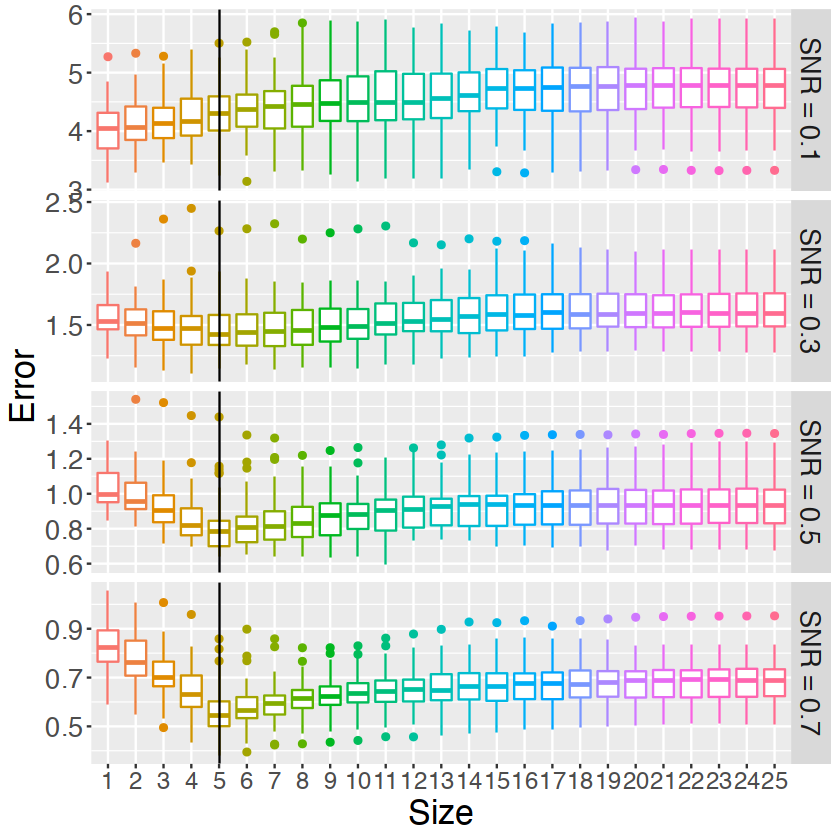

In [5]:
ggplot(data = err, aes(x = Size, y = Error, color = Size)) +
    geom_boxplot() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        axis.text.x = element_text(size = 14),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")

### Cross validation

- Generate data.

- Divide the whole dataset into $K$ folds.

- Each time use $K-1$ folds as the training set and the remaining one as the testing set.

In [6]:
N <- 200
P <- 25
p_true <- 5
SNR_vec <- c(0.1, 0.3, 0.5, 0.7) # We will evaluate the performances under different SNR settings

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

In [7]:
nfolds <- 10
dat_idx <- sample(1:N, N, replace = FALSE)
err_cv <- array(0, dim = c(P, length(SNR_vec), nfolds))
for (i in 1:length(SNR_vec)) {
    SNR <- SNR_vec[i]
    y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR)) # Noisy observation
    dat <- data.frame(y = y, X) # Whole dataset
    
    for (k in 1:nfolds) {
        idx_test <- dat_idx[((k - 1) * N / nfolds + 1):(k * N / nfolds)]

        regfit_cv <- regsubsets(y ~ ., data = dat[-idx_test, ], nvmax = P)
        for (p in 1:P) {
            pred <- predict(regfit_cv, dat[idx_test, ], id = p)
            err_cv[p, i, k] <- mean((y[idx_test] - c(pred))^2)
        }
    }
}

In [8]:
err_cv <- data.frame(1:P, apply(err_cv, MARGIN = c(1, 2), FUN = mean))
colnames(err_cv) <- c("Size", paste0("SNR = ", SNR_vec))
head(err_cv)

Size SNR = 0.1 SNR = 0.3 SNR = 0.5 SNR = 0.7
1 1    4.280570  1.827893  1.2416056 0.9266315
2 2    4.204426  1.712600  1.1593035 0.8858508
3 3    4.178623  1.723119  1.0540198 0.7632093
4 4    4.282461  1.652721  1.0082264 0.7000183
5 5    4.225401  1.710546  0.9743102 0.5852064
6 6    4.188506  1.771243  0.9512825 0.6094600

In [9]:
err_cv <- melt(
    data = err_cv,
    id.vars = "Size",
    variable.name = "SNR",
    value.name = "Testing error"
)
head(err_cv)

Size SNR       Testing error
1 1    SNR = 0.1 4.280570     
2 2    SNR = 0.1 4.204426     
3 3    SNR = 0.1 4.178623     
4 4    SNR = 0.1 4.282461     
5 5    SNR = 0.1 4.225401     
6 6    SNR = 0.1 4.188506

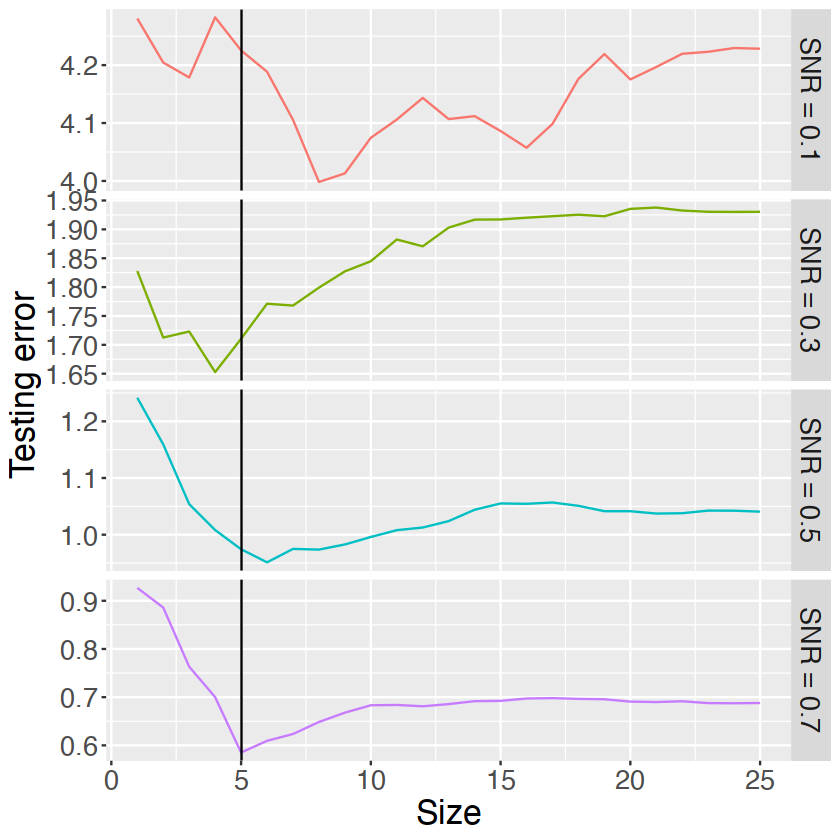

In [10]:
ggplot(data = err_cv, aes(x = Size, y = `Testing error`, color = SNR)) +
    geom_line() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")

### A wrong evaluation scheme

- Generate data.

- Use the whole dataset as training set and perform best subset selection.

- Divide the dataset into $K$ folds.

- Each time use $K-1$ folds as the training set and the remaining one as the testing set.

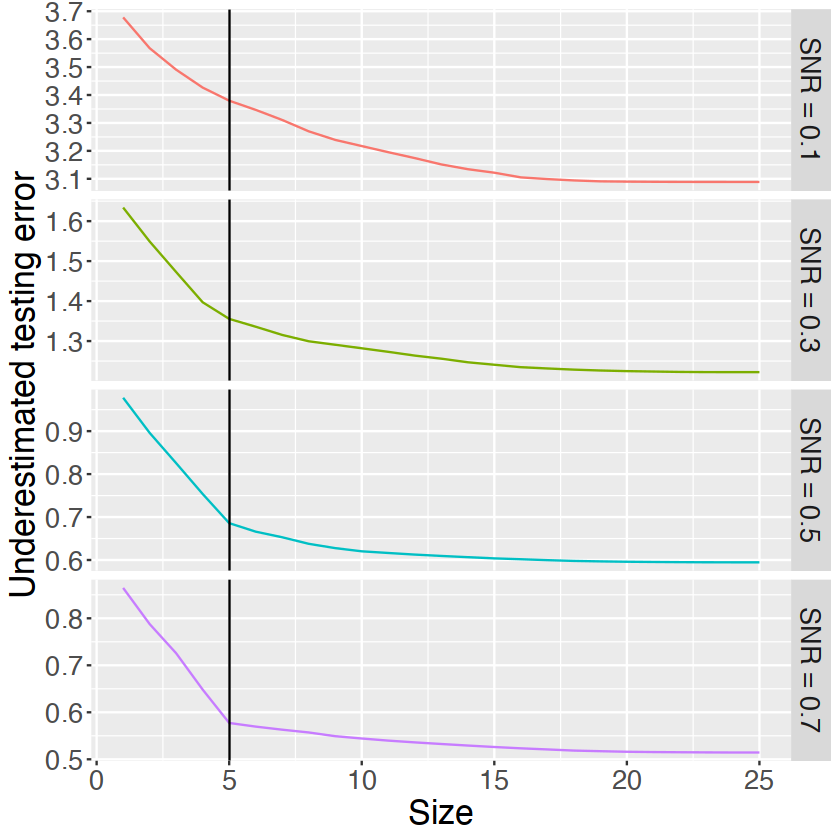

In [11]:
N <- 200
P <- 25
p_true <- 5
SNR_vec <- c(0.1, 0.3, 0.5, 0.7) # We will evaluate the performances under different SNR settings

beta <- rep(0, P)
beta[1:p_true] <- 1 # The first p_true predictors have non-zero effects

X <- matrix(runif(N * P), N, P)
colnames(X) <- paste0("X", 1:P)
y0 <- X %*% as.matrix(beta)

X <- data.frame(X)
colnames(X) <- paste0("X", 1:P)

nfolds <- 10
dat_idx <- sample(1:N, N, replace = FALSE)
err_cv <- array(0, dim = c(P, length(SNR_vec), nfolds))
for (i in 1:length(SNR_vec)) {
    SNR <- SNR_vec[i]
    y <- y0 + rnorm(N, sd = sqrt(var(y0) / SNR))
    dat <- data.frame(y = y, X) # Whole dataset
    regfit_cv <- regsubsets(y ~ ., data = dat, nvmax = P) # Perform best subset selection using the whole dataset
    
    for (k in 1:nfolds) {
        idx_test <- dat_idx[((k - 1) * N / nfolds + 1):(k * N / nfolds)]

        for (p in 1:P) {
            pred <- predict(regfit_cv, dat[idx_test, ], id = p)
            err_cv[p, i, k] <- mean((y[idx_test] - c(pred))^2)
        }
    }
}

err_cv <- data.frame(1:P, apply(err_cv, MARGIN = c(1, 2), FUN = mean))
colnames(err_cv) <- c("Size", paste0("SNR = ", SNR_vec))

err_cv <- melt(
    data = err_cv,
    id.vars = "Size",
    variable.name = "SNR",
    value.name = "Underestimated testing error"
)

ggplot(data = err_cv, aes(x = Size, y = `Underestimated testing error`, color = SNR)) +
    geom_line() +
    geom_vline(xintercept = p_true, color = "black") + # True predictors
    theme(
        text = element_text(size = 20),
        legend.position = "none"
    ) +
    facet_grid(SNR ~ ., scales = "free_y")